In [1]:
from subject_braintreebank import BrainTreebankSubject
from subject_mgh import MGHSubject
from train_utils import log
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

def load_subject_trials(subject_trials, dtype, cache=False, allow_corrupted=False):
    all_subject_identifiers = [subject_identifier for subject_identifier, trial_id in subject_trials]
    all_subject_identifiers = list(set(all_subject_identifiers))
    all_subjects = {}

    for subject_identifier in all_subject_identifiers:
        log(f"loading subject {subject_identifier}...", indent=1, priority=1)
        if "btbank" in subject_identifier:
            subject_id = int(subject_identifier.replace("btbank", ""))
            all_subjects[subject_identifier] = BrainTreebankSubject(subject_id, dtype=dtype, cache=cache, allow_corrupted=allow_corrupted)
        elif "mgh" in subject_identifier:
            subject_id = int(subject_identifier.replace("mgh", ""))
            all_subjects[subject_identifier] = MGHSubject(subject_id, dtype=dtype, cache=cache, allow_corrupted=allow_corrupted, use_h5_file=True)
        else:
            raise ValueError(f"Unknown subject identifier: {subject_identifier}")
        for trial_id in [trial_id for _subject_identifier, trial_id in subject_trials if _subject_identifier == subject_identifier]:
            log(f"loading trial {trial_id}...", indent=2, priority=1)
            all_subjects[subject_identifier].load_neural_data(trial_id)

    return all_subjects

In [2]:
subject_trials = [("mgh1", 3)]
all_subjects = load_subject_trials(subject_trials, dtype=torch.float32, cache=True, allow_corrupted=False)

[12:02:55 gpu 0.0G ram 0.5G] (1)     loading subject mgh1...
[12:02:55 gpu 0.0G ram 0.5G] (1)         loading trial 3...


In [4]:
window_size_seconds = 100

subject_identifier, trial_id = subject_trials[0]

subject = all_subjects[subject_identifier]
sampling_rate = subject.get_sampling_rate(0)
window_size_samples = int(window_size_seconds * sampling_rate)
all_electrode_data = subject.get_all_electrode_data(3, window_from=100000, window_to=100000 + window_size_samples)
all_electrode_data

tensor([[-4.6655e-05, -4.2668e-05, -4.2136e-05,  ...,  7.8424e-06,
          6.5131e-06,  4.1206e-06],
        [-7.4037e-05, -6.7923e-05, -6.6328e-05,  ..., -5.9815e-06,
         -8.1082e-06, -1.1032e-05],
        [-1.0142e-04, -9.7431e-05, -9.4507e-05,  ..., -3.2566e-05,
         -3.2566e-05, -3.6819e-05],
        ...,
        [-1.1471e-04, -2.0324e-04, -2.0669e-04,  ...,  8.3740e-06,
         -4.0275e-05, -5.4365e-05],
        [-9.3710e-05, -1.7984e-04, -1.8197e-04,  ...,  1.3425e-05,
         -3.6022e-05, -4.7187e-05],
        [-3.4161e-05, -9.7166e-05, -9.4241e-05,  ...,  3.7351e-05,
          4.9181e-06, -6.6461e-07]])

In [7]:
n_electrodes = subject.get_n_electrodes(session_id=trial_id)
random_electrodes = np.random.choice(range(all_electrode_data.shape[0]), size=n_electrodes, replace=False) if n_electrodes < all_electrode_data.shape[0] else np.arange(all_electrode_data.shape[0])
random_electrodes_data = all_electrode_data[random_electrodes]
random_electrodes_labels = [f"{subject.subject_identifier}_{trial_id}_{subject.get_electrode_labels(session_id=trial_id)[electrode_id]}" for electrode_id in random_electrodes]

# Convert all electrode data to numpy and calculate autocorrelation for each
all_electrode_data_np = [electrode_data.numpy() for electrode_data in random_electrodes_data]
autocorrelation_window_size = 1 # in seconds
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Calculate autocorrelation for each electrode
autocorrs = []
for electrode_data in all_electrode_data_np:
    # Calculate autocorrelation using numpy correlate
    autocorr = np.correlate(electrode_data, electrode_data[:-int(autocorrelation_window_size*sampling_rate)], mode='valid')
    # Normalize by first value
    autocorr /= autocorr[0]
    autocorrs.append(autocorr)

# Convert to numpy array for easier handling
autocorr = np.array(autocorrs)

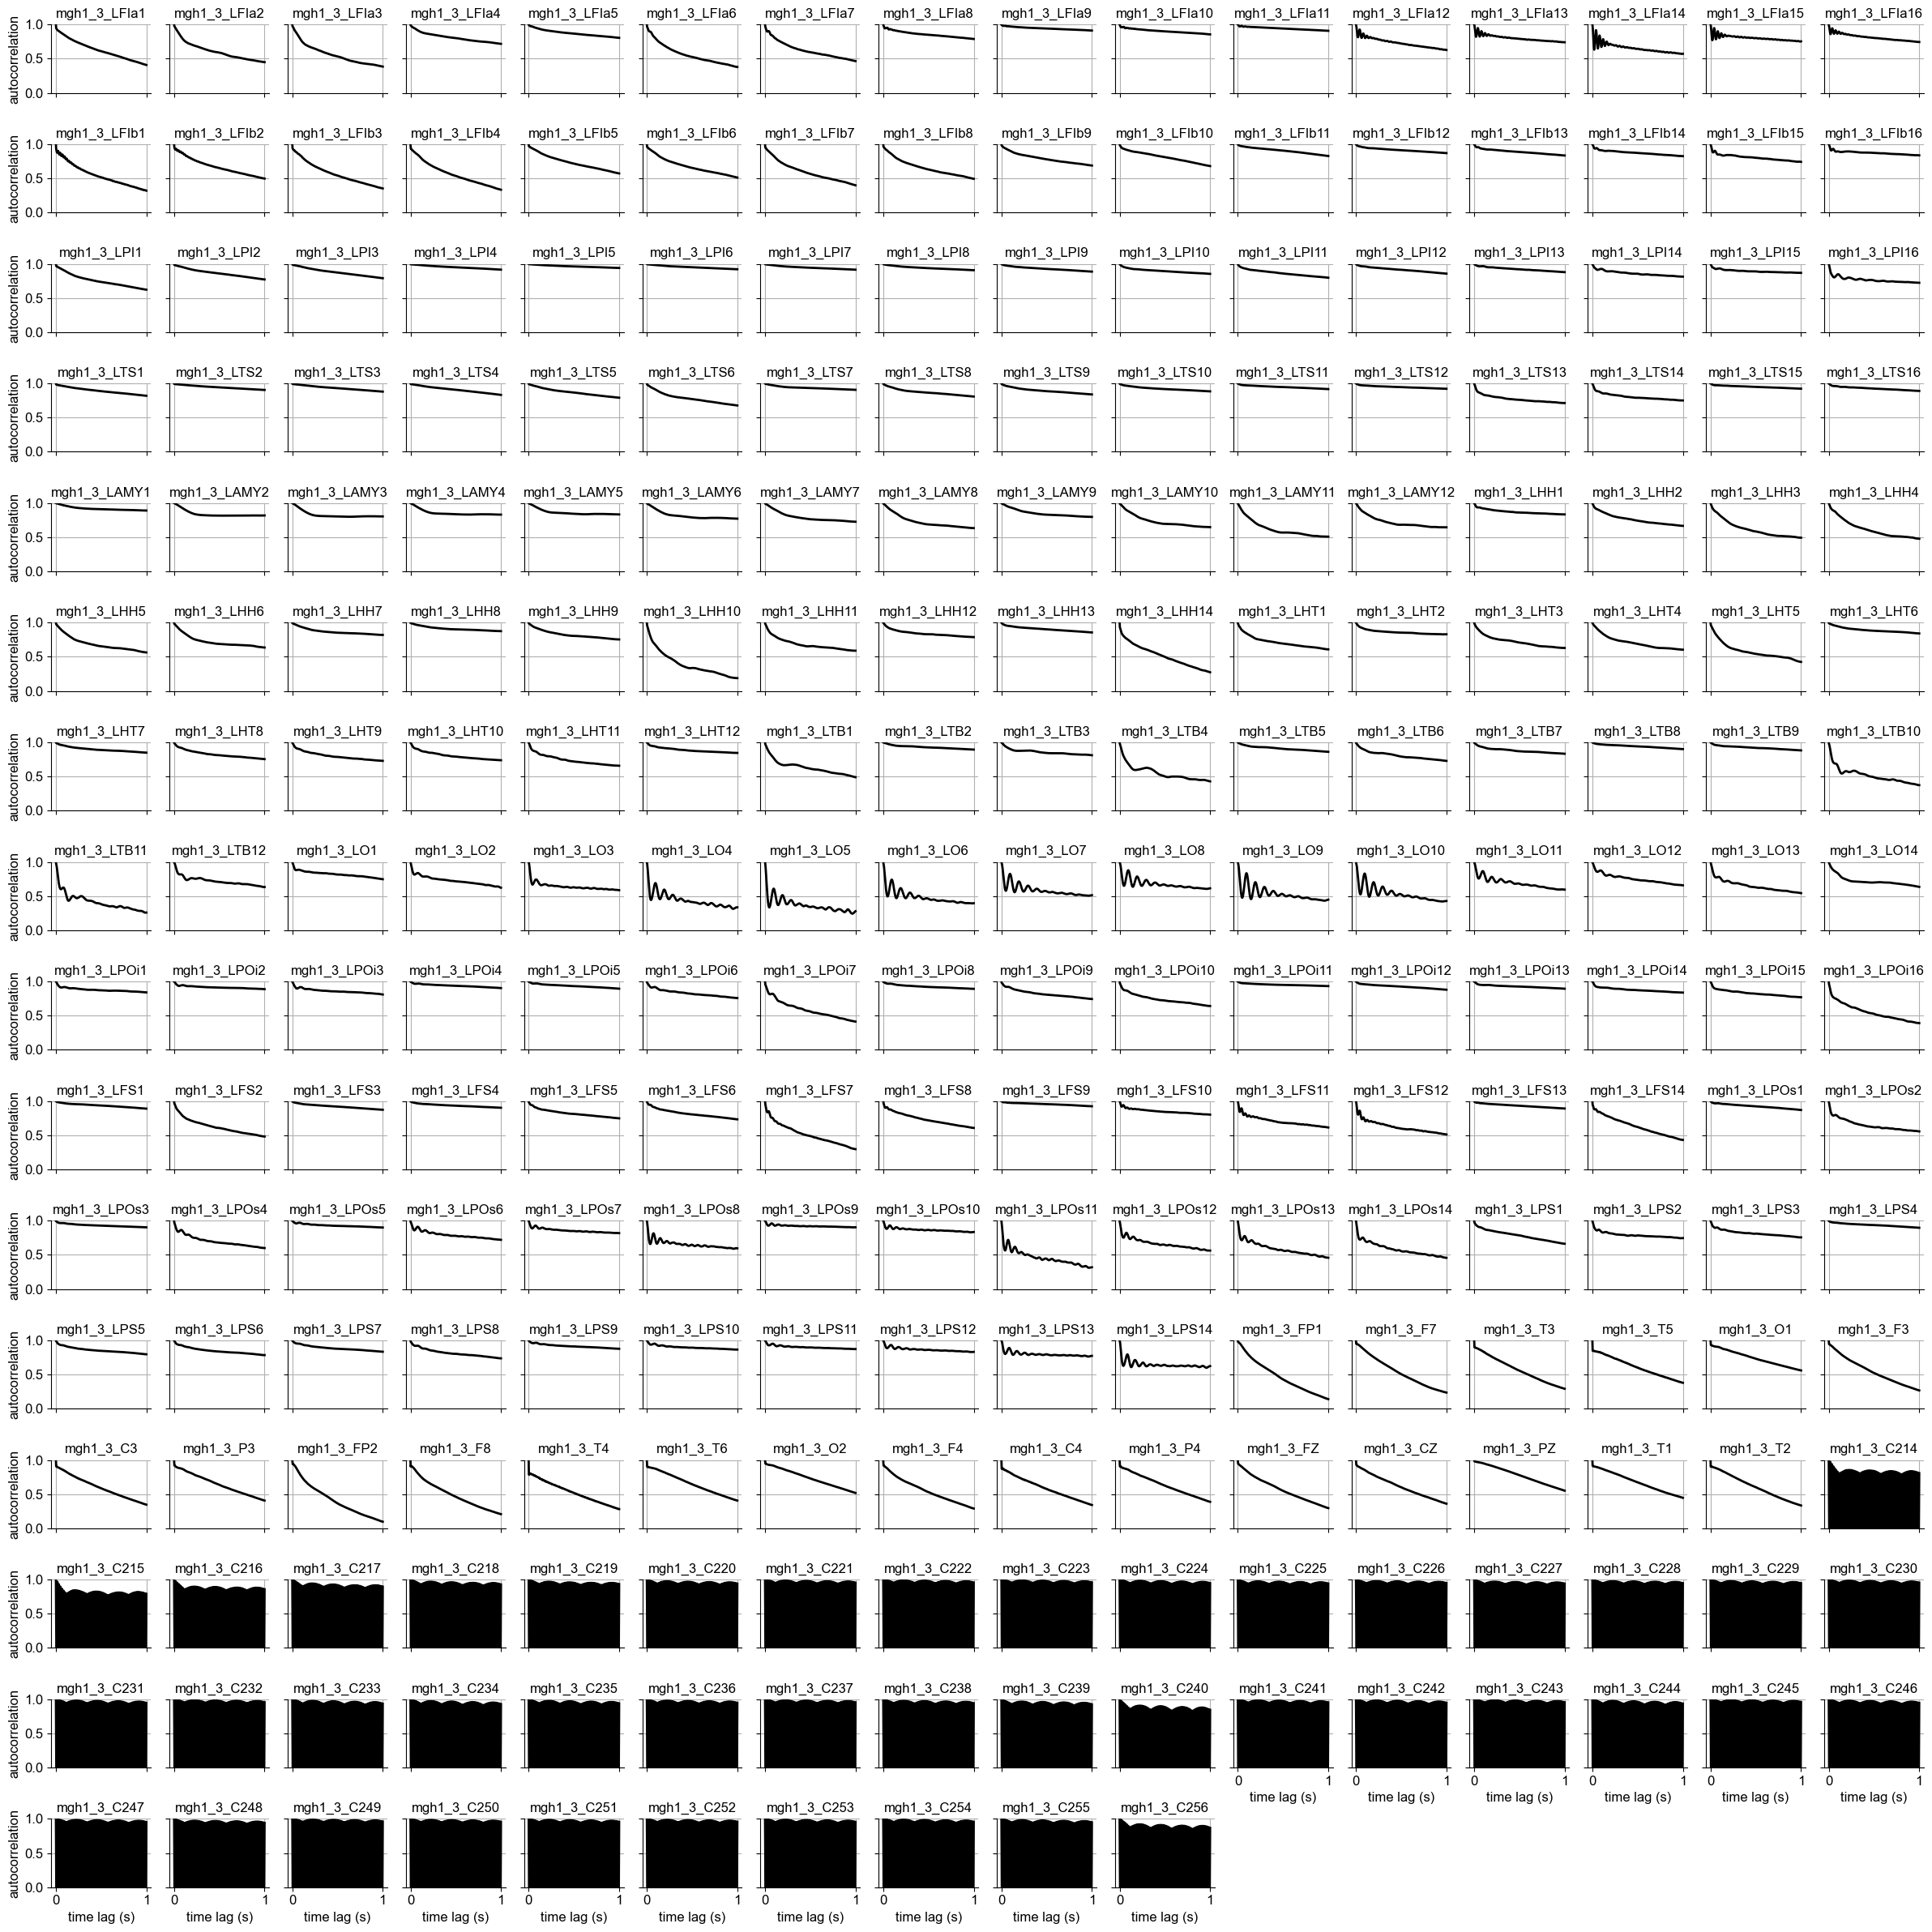

In [8]:
# Create time axis in seconds for full autocorrelation
lags = np.arange(0, autocorrelation_window_size*sampling_rate+1)
time_lags = lags / sampling_rate

# Calculate grid dimensions
grid_size = int(np.ceil(np.sqrt(n_electrodes)))

# Plot the autocorrelation
fig, axes = plt.subplots(grid_size, grid_size, figsize=(24, 24))# figsize=(12, 12))
axes = axes.flatten()

# Plot each electrode in a separate subplot
for i in range(n_electrodes):
    ax = axes[i]
    ax.plot(time_lags, autocorr[i], linewidth=2, color='black')
    ax.set_title(f'{random_electrodes_labels[i]}', fontsize=12)
    ax.grid(True)
    
    # Only show x-axis labels for bottom row
    if i < n_electrodes - grid_size:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('time lag (s)')
        
    # Only show y-axis labels for leftmost column
    if i % grid_size != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('autocorrelation')
    
    ax.set_ylim(0, 1)
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Remove any empty subplots
for i in range(n_electrodes, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


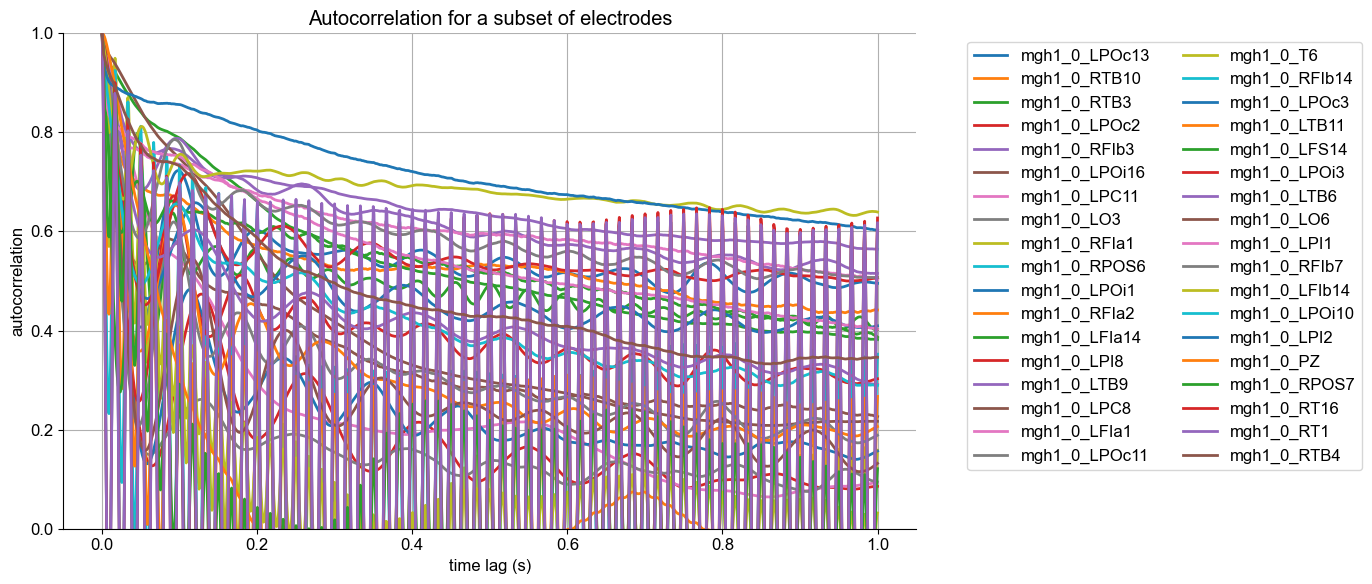

In [122]:
# Create time axis in seconds for full autocorrelation
lags = np.arange(0, autocorrelation_window_size*sampling_rate+1)
time_lags = lags / sampling_rate

# Plot the autocorrelation
plt.figure(figsize=(14, 6))

# Plot each electrode
for i in range(n_electrodes):
    plt.plot(time_lags, autocorr[i], linewidth=2, label=random_electrodes_labels[i])

plt.xlabel('time lag (s)')
plt.ylabel('autocorrelation')
plt.title('Autocorrelation for a subset of electrodes')
plt.grid(True)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


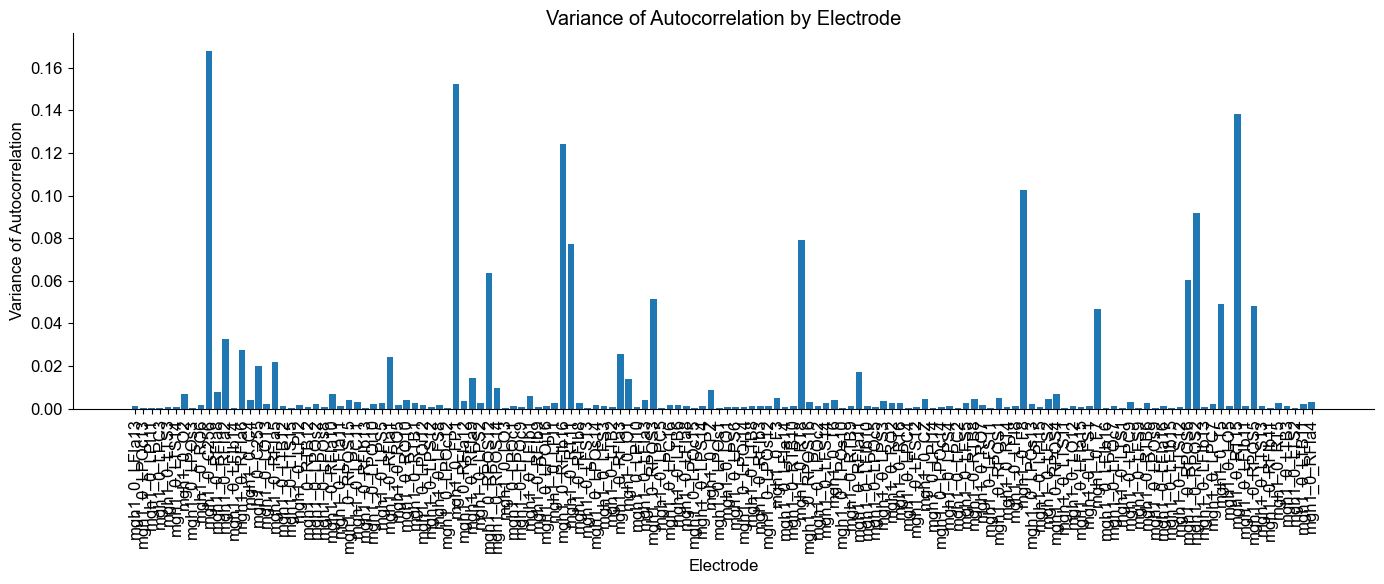

In [137]:
# Calculate variance for each electrode
variances = autocorr[:, 300:].var(axis=1)

# Create histogram
plt.figure(figsize=(14, 6))
plt.bar(range(len(variances)), variances)
plt.xticks(range(len(variances)), random_electrodes_labels, rotation=90)
plt.xlabel('Electrode')
plt.ylabel('Variance of Autocorrelation')
plt.title('Variance of Autocorrelation by Electrode')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

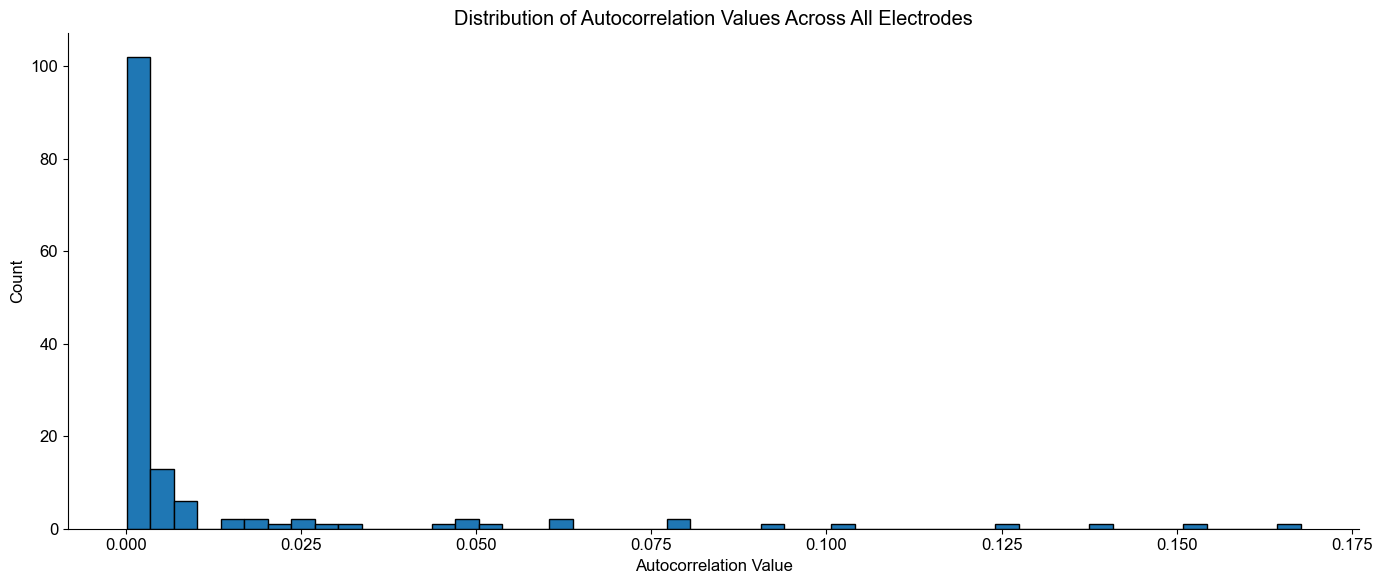

In [136]:
# Flatten autocorrelation values across all electrodes
all_correlations = autocorr[:, 300:].var(axis=1).flatten()

# Create histogram of all correlation values
plt.figure(figsize=(14, 6))
plt.hist(all_correlations, bins=50, edgecolor='black')
plt.xlabel('Autocorrelation Value')
plt.ylabel('Count')
plt.title('Distribution of Autocorrelation Values Across All Electrodes')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()